# Load and visualize pytorch models 

## Preamble

In [32]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import numpy as np
from utils import losses
import pytorch_lightning as pl

from architectures import AR, GRU, LSTM, TGCN

## Plotting packages
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"


In [9]:

init_model_AR = AR(input_dim = 72, output_dim = 1, loss_fn=losses.censored_poisson_negative_log_likelihood, censored=True)
init_model_GRU = GRU(input_dim = 72,  hidden_dim = 72, output_dim = 1, loss_fn=losses.censored_poisson_negative_log_likelihood, censored=True)
init_model_LSTM = LSTM(input_dim = 72,  hidden_dim = 72, output_dim = 1, loss_fn=losses.censored_poisson_negative_log_likelihood, censored=True)
#init_model_TGCN = TGCN()

model_AR = init_model_AR.load_from_checkpoint(r"../trained_models/best_model_AR_CPNLL.ckpt")
model_GRU = init_model_GRU.load_from_checkpoint(r"../trained_models/best_model_GRU_CPNLL.ckpt")
model_LSTM = init_model_LSTM.load_from_checkpoint(r"../trained_models/best_model_LSTM_CPNLL.ckpt")

print(model_AR)
print(model_GRU)
print(model_LSTM)

AR(
  (fc1): Linear(in_features=72, out_features=1, bias=True)
)
GRU(
  (gru): GRU(72, 72, batch_first=True)
  (linear): Linear(in_features=72, out_features=1, bias=True)
)
LSTM(
  (lstm): LSTM(72, 72, batch_first=True)
  (linear): Linear(in_features=72, out_features=1, bias=True)
)


In [7]:
df = pd.read_csv("../trained_models/predictions_TemporalGCN_CPNLL.csv", index_col=0)
df.head()

,HAMILTON,HIGH,BRYANT,MPL,RINCONADA,WEBSTER,TED,CAMBRIDGE,HAMILTON_pred,HIGH_pred,BRYANT_pred,MPL_pred,RINCONADA_pred,WEBSTER_pred,TED_pred,CAMBRIDGE_pred
0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.219728,0.195388,0.198143,1.238582,0.628735,0.197384,0.581606,0.723338
1,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.279463,0.236870,0.243383,1.397314,1.701476,0.270071,0.821443,0.642196
2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.283013,0.235700,0.248969,1.248382,1.374772,0.287578,0.370918,0.306925
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.281091,0.232443,0.249188,0.280539,1.288548,0.290639,0.245200,0.204660
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.236795,0.200773,0.215205,0.146230,0.627193,0.236575,0.171167,0.147564


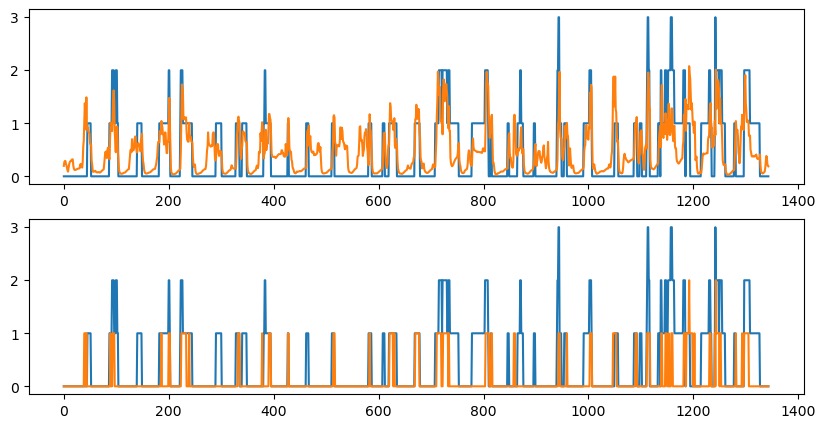

In [16]:
# Plot the prediction and the true value
CLUSTER = "WEBSTER"
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].plot(df[CLUSTER], label="True")
axs[1].plot(df[CLUSTER], label="True")
axs[0].plot(df[f"{CLUSTER}_pred"], label="Pred")
axs[1].plot(df[f"{CLUSTER}_pred"].astype(int), label="Pred")

## Non-spatial predictions

In [38]:
df_test = pd.read_csv("../predictions/predictions_LSTM_CPNLL.csv", index_col=0)
df_test = df_test.rename(columns = {'WEBSTER': 'y_tau' ,'WEBSTER_pred': 'LSTM'})

## Add predictions from other models
df_test['GRU'] = pd.read_csv("../predictions/predictions_GRU_CPNLL.csv", index_col=0)['WEBSTER_pred']
df_test['AR'] = pd.read_csv("../predictions/predictions_AR_CPNLL.csv", index_col=0)['WEBSTER_pred']
df_test['ARNet'] = pd.read_csv("../predictions/predictions_ARNet_CPNLL.csv", index_col=0)['WEBSTER_pred']

In [41]:
len(pd.read_csv("../predictions/predictions_AR_CPNLL.csv", index_col=0)['WEBSTER_pred'])

1536

In [43]:
pd.read_csv("../predictions/predictions_LSTM_CPNLL.csv", index_col=0)

,WEBSTER,WEBSTER_pred
0,2.0,0.775832
1,1.0,2.813623
2,1.0,2.104456
3,0.0,3.354190
4,2.0,2.055338
...,...,...
1531,2.0,NaN
1532,0.0,NaN
1533,0.0,NaN
1534,0.0,NaN


In [39]:
## Add uncensored observations
TEST_START = '2019-05-01 00:30:00'
TEST_END = '2019-06-02 00:00:00'


df_uncensored = pd.read_csv('../data/charging_session_count_1_to_30.csv', parse_dates=['Period'])
test_start_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_START].index.values[0] + 24
test_end_uncensored  = df_uncensored[df_uncensored['Period'] == TEST_END].index.values[0] + 25

df_test['Uncensored observations'] = df_uncensored[test_start_uncensored:test_end_uncensored]['WEBSTER'].values

df_test.loc[df_test['Uncensored observations'] < 2, 'Uncensored observations'] = 2

In [40]:
df_test

,y_tau,LSTM,GRU,AR,ARNet,Uncensored observations
0,2.0,0.775832,3.313771,1.418113,0.290902,3.0
1,1.0,2.813623,2.308312,0.197737,2.457201,3.0
2,1.0,2.104456,4.065341,3.242785,2.624889,2.0
3,0.0,3.354190,2.617695,4.466697,5.381716,3.0
4,2.0,2.055338,0.478079,2.107973,2.336493,3.0
...,...,...,...,...,...,...
1531,2.0,NaN,NaN,3.451153,0.293564,2.0
1532,0.0,NaN,NaN,0.732588,2.697670,2.0
1533,0.0,NaN,NaN,3.255702,0.146626,2.0
1534,0.0,NaN,NaN,1.075976,0.115514,2.0


In [36]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

#test_index = df_test[df_test['Period'] == TEST_START].index.values[0]

fig = px.line(df_test[300:], labels=dict(created_at="Date", value="Sessions"))
#fig.add_vline(x=test_index, line_width=4, line_dash="dash")
#fig.add_annotation(xref="paper", x=0.85, yref="paper", y=-0.2, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.06, title_text="")
)
fig.show()